In [1]:
import numpy as np

# Cavity parameters
L = 0.1                        # Cavity Length
RcM2 = 0.5                     # Radius of curvature of M2 mirror = 0.5 m
g1 = 1                         # g1 = 1 - L/RcM1 = 1 since RcM1 = infinity
g2 = 1 - L/RcM2                # g2 for M2 mirror
print("g1g2 =", g1*g2)         # Stability check

# Mirror Tilt:
npoints = 200
theta_low = -1e-6
theta_high = 1e-6

def geometric(mirror, theta_low, theta_high, npoints):
    if mirror == 1:
        # M1 tilt
        theta_1 = np.linspace(theta_low, theta_high, npoints+1, endpoint=True)
        # M2 tilt
        theta_2 = 0
    elif mirror == 2:
        # M1 tilt
        theta_1 = 0
        # M2 tilt
        theta_2 = np.linspace(theta_low, theta_high, npoints+1, endpoint=True)
    else:
        raise NotImplementedError("Mirror should be 1 or 2 and an integer")

    # Resultant translation
    ## Displacement on M1
    delta_x1 = (g2/(1-g1*g2))*L*theta_1 - (1/(1- g1*g2))*L*theta_2
    ## Displacement on M2
    delta_x2 = (1/(1-g1*g2))*L*theta_1 - (g1/(1-g1*g2))*L*theta_2
    ## Angular displacement of optical axis
    delta_theta = (delta_x2 - delta_x1)/L

    print("Results for analytical solutions:")
    print("∆x1: ", max(delta_x1), min(delta_x1), " m")
    print("∆x2: ", max(delta_x2), min(delta_x2), " m")
    print("∆θ: ", max(delta_theta), min(delta_theta), " m")

    return delta_x1, delta_x2, delta_theta

g1g2 = 0.8


In [2]:
import matplotlib.pyplot as plt
import finesse
from finesse import init_plotting
init_plotting()

T = 1e-6

# Build Finesse model
kat = finesse.Model()
kat.parse(
    f"""
    laser laser P=1.0 f=0 phase=0

    # Mirrors
    mirror M1 R=1-M1.T T={T} L=0.0 phi=0 Rc=[inf, inf] xbeta=0 ybeta=0
    mirror M2 R=1-M1.T T=M1.T L=0.0 phi=0 Rc=[{RcM2}, {RcM2}] xbeta=0 ybeta=0

    # Spaces
    space s0 portA=laser.p1 portB=M1.p1 L=1 nr=1
    space s_cav portA=M1.p2 portB=M2.p1 L=0.1 nr=1

    # Amplitude Detectors
    amplitude_detector det00_1 node=M1.p2.i f=0 n=0 m=0
    amplitude_detector det00_2 node=M2.p1.o f=0 n=0 m=0
    amplitude_detector det10_1 node=M1.p2.i f=0 n=1 m=0
    amplitude_detector det10_2 node=M2.p1.o f=0 n=1 m=0

    # Beam Property Detectors
    beam_property_detector bp_n2 prop=0 node=M1.p2.i direction=x q_as_bp=false
    beam_property_detector bp_n3 prop=0 node=M2.p1.o direction=x q_as_bp=false
    beam_property_detector cavwaist prop=1 node=M1.p2.i direction=x q_as_bp=false

    # Photodiodes
    power_detector_dc pcirc node=M1.p2.o pdtype=none

    # Config
    cavity cavity1 source=M1.p2.o via=M2.p1.i priority=1
    lambda(1.064e-06)
    modes(maxtem=3)
    """
)

# Print beam tracing information
tsy = finesse.tracing.tools.propagate_beam(
    to_node=kat.M2.p1.o, from_node=kat.M1.p2.o, direction="y"
)
print(tsy.table())

┌─────────╥────────┬───────────┬────────┬───────────┬─────────┬──────┬───────────┬─────────────────┐
│         ║   z    │    w0     │   zr   │     w     │   RoC   │  S   │ Acc. Gouy │        q        │
╞═════════╬════════╪═══════════╪════════╪═══════════╪═════════╪══════╪═══════════╪═════════════════╡
│ M1.p2.o ║    0 m │ 260.26 um │ 200 mm │ 260.26 um │   inf m │  0 D │        0° │  0.000 + 0.200j │
├─────────╫────────┼───────────┼────────┼───────────┼─────────┼──────┼───────────┼─────────────────┤
│ M2.p1.i ║ 100 mm │ 260.26 um │ 200 mm │ 290.98 um │  500 mm │  2 D │   26.565° │  0.100 + 0.200j │
├─────────╫────────┼───────────┼────────┼───────────┼─────────┼──────┼───────────┼─────────────────┤
│ M2.p1.o ║ 100 mm │ 260.26 um │ 200 mm │ 290.98 um │ -500 mm │ -2 D │   26.565° │ -0.100 + 0.200j │
└─────────╨────────┴───────────┴────────┴───────────┴─────────┴──────┴───────────┴─────────────────┘



In [3]:
def run_simulation(mirror, theta_low, theta_high, npoints):
    kat.parse(
        f"""
        # Actions
        xaxis(
            parameter=M{mirror:.0f}.xbeta,
            mode=lin,
            start={theta_low},
            stop={theta_high},
            steps={npoints},
            pre_step=none,
            post_step=none
        )
        """
    )
    return process_sim(kat.run())

def process_sim(out):
    # Comparison
    acirc = np.sqrt(out["pcirc"].real) # circulating amplitude

    # intermodal phase HG10 -> HG00
    # at mirror 1
    intermodal_phase_1 = np.angle(out["det10_1"]) - np.angle(out["det00_1"])
    # at mirror 2
    intermodal_phase_2 = np.angle(out["det10_2"]) - np.angle(out["det00_2"])

    # Real part of \power normalised HG10 mode ampltiude
    # at M1
    a_shift_1 = (np.abs(out["det10_1"])/acirc)*np.cos(intermodal_phase_1)
    # at M2
    a_shift_2 = (np.abs(out["det10_2"])/acirc)*np.cos(intermodal_phase_2)

    # Imaginary part of power normalised HG10 mode ampltiude
    # at M1
    a_tilt_1 = (np.abs(out["det10_1"])/acirc)*np.sin(intermodal_phase_1)
    # at M2
    a_tilt_2 = (np.abs(out["det10_2"])/acirc)*np.sin(intermodal_phase_2)

    # Spot position shift
    # at M1
    dx_finesse_1 = out["bp_n2"].real*a_shift_1
    # at M2
    dx_finesse_2 = out["bp_n3"].real*a_shift_2

    # Wavefront tilt at
    # M1
    dtheta_1 = a_tilt_1*kat.lambda0/(np.pi*out["cavwaist"].real)
    # M2
    dtheta_2 = a_tilt_2*kat.lambda0/(np.pi*out["cavwaist"].real)

    print("Results for finesse solutions:")
    print("Intermodal_1: ", max(intermodal_phase_1/np.pi), min(dx_finesse_1/np.pi), " pi")
    print("Intermodal_2: ", max(intermodal_phase_2/np.pi), min(dx_finesse_2/np.pi), " pi")

    print("∆x1: ", max(dx_finesse_1), min(dx_finesse_1), " m")
    print("∆x2: ", max(dx_finesse_2), min(dx_finesse_2), " m")
    print("∆θ1: ", max(dtheta_1), min(dtheta_1), " m")
    print("∆θ2: ", max(dtheta_2), min(dtheta_2), " m")

    return (
        intermodal_phase_1,
        intermodal_phase_2,
        dx_finesse_1,
        dx_finesse_2,
        dtheta_1,
        dtheta_2,
        out.x[0]
    )

Results for analytical solutions:
∆x1:  4.0000000000000014e-07 -4.0000000000000014e-07  m
∆x2:  5.000000000000001e-07 -5.000000000000001e-07  m
∆θ:  9.999999999999993e-07 -9.999999999999993e-07  m


Results for finesse solutions:
Intermodal_1:  0.14758329930279382 -1.273240787814041e-07  pi
Intermodal_2:  -3.1834763941235237e-07 -1.5915492491370067e-07  pi
∆x1:  4.000003905247471e-07 -4.0000039052474715e-07  m
∆x2:  4.999999428915172e-07 -4.999999428915172e-07  m
∆θ1:  9.999955236676984e-07 -9.999955236676976e-07  m
∆θ2:  4.876993207838182e-12 -4.8769932079878946e-12  m
Results for analytical solutions:
∆x1:  5.000000000000001e-07 -5.000000000000001e-07  m
∆x2:  5.000000000000001e-07 -5.000000000000001e-07  m
∆θ:  0.0 0.0  m


Results for finesse solutions:
Intermodal_1:  1.5161488574404476e-07 -1.591551193134631e-07  pi
Intermodal_2:  0.8524165339644525 -1.5915515721722656e-07  pi
∆x1:  5.000005536163827e-07 -5.000005536163827e-07  m
∆x2:  5.000006726945675e-07 -5.000006726945675e-07  m
∆θ1:  1.1907818465421746e-12 -1.1907818474034485e-12  m
∆θ2:  1.118034161606098e-06 -1.1180341616060985e-06  m


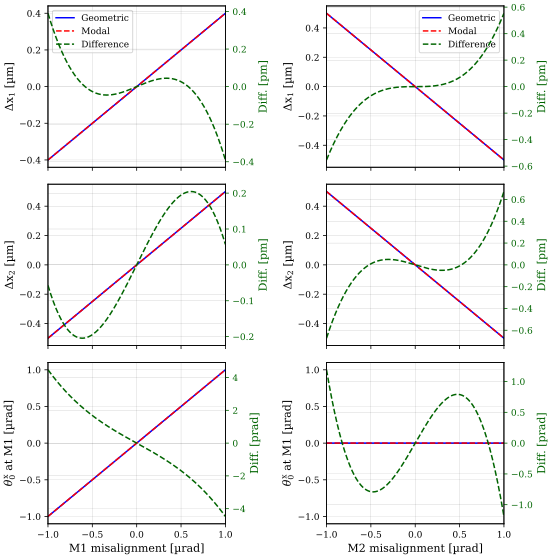

In [4]:
def comparison_plot(mirror, theta_low, theta_high, npoints, ax=None):

    delta_x1, delta_x2, delta_theta = geometric(
        mirror, theta_low, theta_high, npoints
    )

    (
        intermodal_phase_1,
        intermodal_phase_2,
        dx_finesse_1,
        dx_finesse_2,
        dtheta_1,
        dtheta_2,
        xaxis
    ) = run_simulation(mirror, theta_low, theta_high, npoints)

    if ax is None:
        fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(4, 6/3*4))

    xaxis = 1e6 * xaxis

    ax2col = "darkgreen"

    # Plot dx1
    l3, = ax[0].plot(xaxis, 1e6*delta_x1, "-", label="Geometric")
    l4, = ax[0].plot(xaxis, 1e6*dx_finesse_1, "--",label="Modal")
    ax[0].plot([], [], "--", color=ax2col, label="Difference")
    ax[0].set_ylabel(r"$\Delta \mathrm{x}_1$ [µm]")

    # Plot dx1 err
    ax1_2 = ax[0].twinx()
    l5, = ax1_2.plot(xaxis, 1e12*(delta_x1 - dx_finesse_1), "--", color=ax2col)
    ax1_2.tick_params(axis="y", colors=ax2col)
    ax1_2.set_ylabel("Diff. [pm]", color=ax2col)

    # plot dx2
    ax[1].plot(xaxis, 1e6*delta_x2, "-", label="Geometric")
    ax[1].plot(xaxis, 1e6*dx_finesse_2, "--", label="Modal")
    ax[1].plot([], [], "--", color=ax2col, label="Difference")
    ax[1].set_ylabel(r"$\Delta \mathrm{x}_2$ [µm]")

    # plot dx2 err
    ax2_2 = ax[1].twinx()
    ax2_2.plot(xaxis, 1e12*(delta_x2 - dx_finesse_2), "--", color=ax2col)
    ax2_2.tick_params(axis="y", colors=ax2col)
    ax2_2.set_ylabel("Diff. [pm]", color=ax2col)

    # plot dtheta1
    ax[2].plot(xaxis, 1e6*delta_theta, "-", label="Geometric")
    ax[2].plot(xaxis, 1e6*dtheta_1, "--", label="Modal")
    ax[2].plot([], [], "--", color=ax2col, label="Difference")
    ax[2].set_ylabel(r"$\theta^\mathrm{x}_0$ at M1 [µrad]")

    # plot dtheta1 err
    ax3_2 = ax[2].twinx()
    ax3_2.plot(xaxis, 1e12*(dtheta_1 - delta_theta), "--", color=ax2col)
    ax3_2.tick_params(axis="y", colors=ax2col)
    ax3_2.set_ylabel("Diff. [prad]",color=ax2col)

    ax[0].legend()
    ax[2].set_xlabel(f"M{mirror} misalignment [µrad]")

fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(8, 6/3*4))
comparison_plot(1, theta_low, theta_high, npoints, ax=ax[:,0])
comparison_plot(2, theta_low, theta_high, npoints, ax=ax[:,1])
ax[2,1].set_ylim([-1.1, +1.1])
fig.tight_layout()

Results for finesse solutions:
Intermodal_1:  0.0 -1.5915511931348423e-07  pi
Intermodal_2:  0.8524168204449615 -1.591552288373988e-07  pi
∆x1:  0.0 -5.000005536164491e-07  m
∆x2:  0.0 -5.000008976959744e-07  m
∆θ1:  1.1174658828196761e-06 -3.4407969937731483e-12  m
∆θ2:  1.7335501779427744e-06 0.0  m
Results for analytical solutions:
∆x1:  0.0 -5.000000000000001e-07  m
∆x2:  0.0 -5.000000000000001e-07  m
∆θ:  0.0 0.0  m


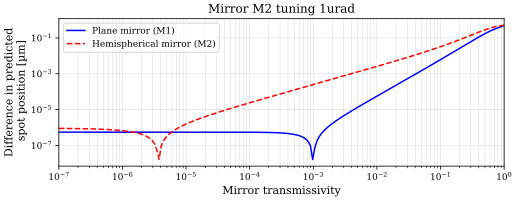

In [5]:
kat.M2.xbeta = theta_high
kat.M1.xbeta = 0
kat.parse(
    f"""
    # Actions
    xaxis(
        parameter=M1.T,
        mode=log,
        start=1e-7,
        stop=1,
        steps={npoints},
        pre_step=none,
        post_step=none)
    """
)

(
    intermodal_phase_1,
    intermodal_phase_2,
    dx_finesse_1,
    dx_finesse_2,
    dtheta_1,
    dtheta_2,
    xaxis
 ) = process_sim(kat.run())

delta_x1, delta_x2, delta_theta = geometric(2, 0, kat.M2.xbeta, npoints)

fig, ax = plt.subplots(figsize=(8,8/3))

## Plot phases
ax.loglog(xaxis, 1e6*np.abs(delta_x1[-1] - dx_finesse_1), "-", label="Plane mirror (M1)")
ax.loglog(xaxis, 1e6*np.abs(delta_x2[-1] - dx_finesse_2), "--", label="Hemispherical mirror (M2)")
ax.set_ylabel("Difference in predicted\n spot position [µm]")
ax.set_xlabel("Mirror transmissivity")
ax.set_title(f"Mirror M2 tuning {1e6*kat.M2.xbeta:.0f}urad")
ax.legend()